# Removing seasonal observation bias from an irregular time series

The ICES database contains observation data for Landsort Deep SST from the 19th century on. Can we find out if there is a long-term trend?

Let us first load the data.

decimalyear,temperature
1877.566,15.40
1891.680,10.40
1893.505,13.55
1898.284,2.07
1898.713,11.53
1899.418,5.56


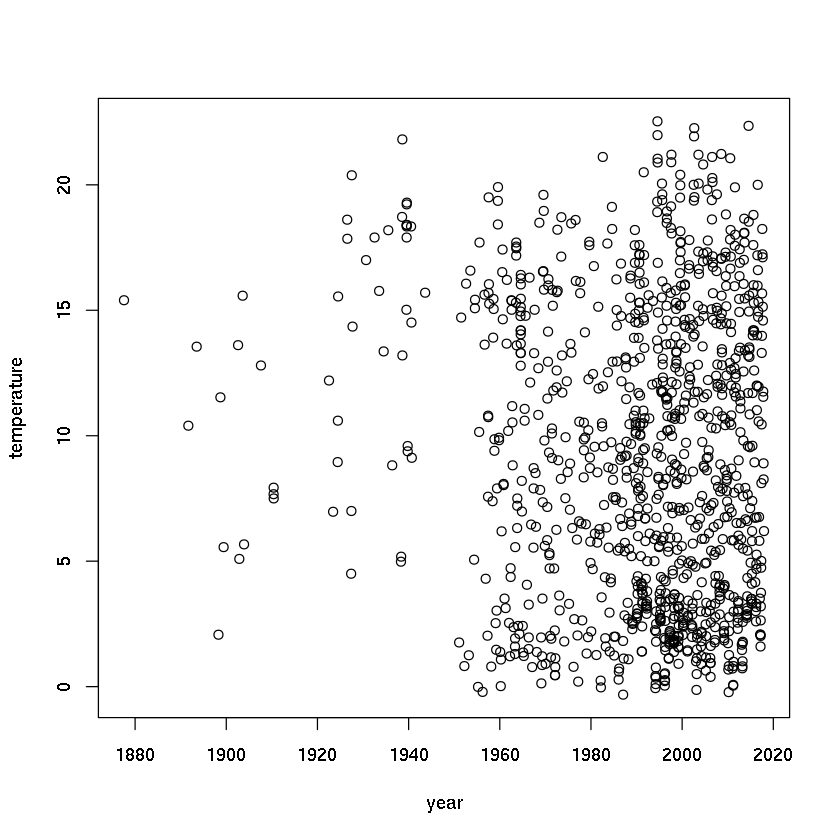

In [3]:
setwd("/silod5/radtke/notebooks/stat_timeseries/seasonal_observation_bias/")
icesdata = read.csv("sst_by31.csv",sep=";")
head(icesdata)
plot(icesdata,xlab = "year")

Let's try to do a GAMM analysis

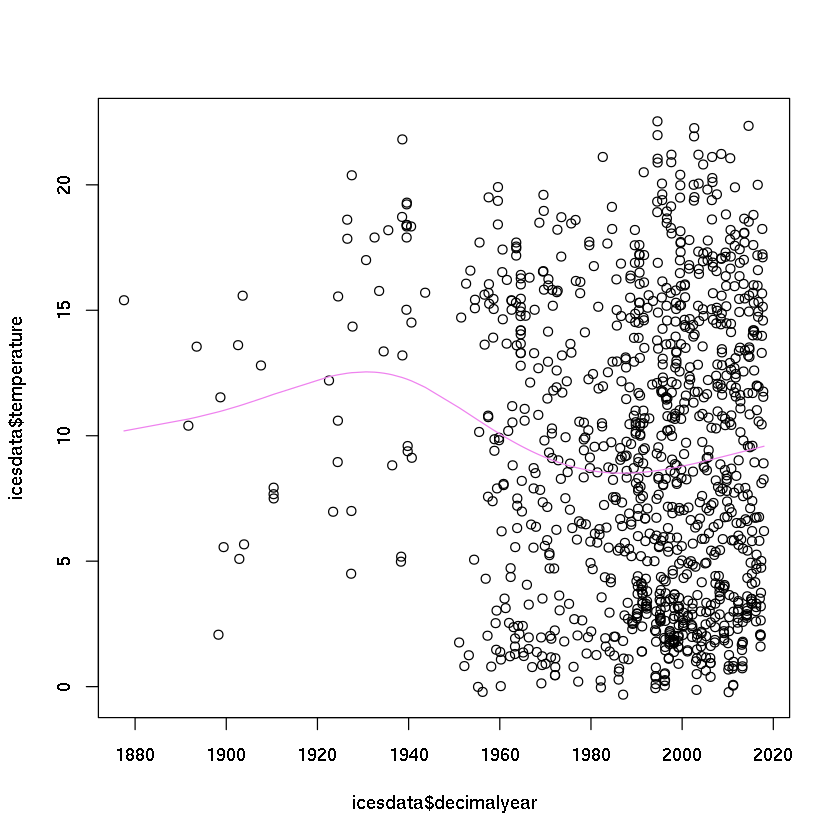

In [4]:
library("mgcv")
x_values = seq(from=1870,to=2020,by=10)
ices_gamm = gamm(temperature ~ s(decimalyear, bs="cr", k = length(x_values)) , data=icesdata, 
                 knots=list(decimalyear=x_values), optimMethod="ML")
plot(icesdata$decimalyear, icesdata$temperature)
lines(icesdata$decimalyear, predict(ices_gamm$gam), col="violet")

That looks weird: Do we really see a cooling here?

These data are irregular and have a pronounced seasonal cycle.

You may find a **seasonal observation bias**: 
Assume you find a long-term trend - is that 
* because it is actually getting warmer, or
* because you measured more often in summer?

Let's add a column **season** to the data frame.

In [9]:
# get the year
icesdata$year = floor(icesdata$decimalyear)
# subtract it from decimalyear to get the season
icesdata$season = icesdata$decimalyear - icesdata$year

head(icesdata)

decimalyear,temperature,year,season
1877.566,15.40,1877,0.5655738
1891.680,10.40,1891,0.6803279
1893.505,13.55,1893,0.5054645
1898.284,2.07,1898,0.2841530
1898.713,11.53,1898,0.7131148
1899.418,5.56,1899,0.4180328


We can now fit a statistical model like this:
$$ temperature = \beta_0 + s_1(decimalyear) + s_2(season) + \varepsilon $$

which explicitly contains seasonality.

This idea follows this online tutorial:
[ https://www.fromthebottomoftheheap.net/2014/05/09/modelling-seasonal-data-with-gam/ ]

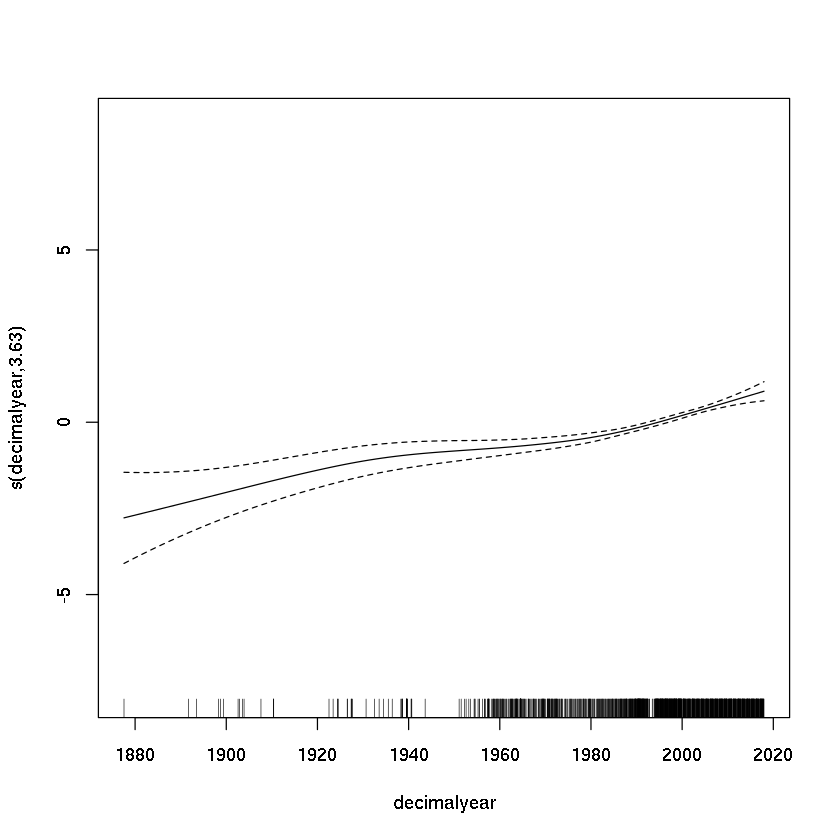

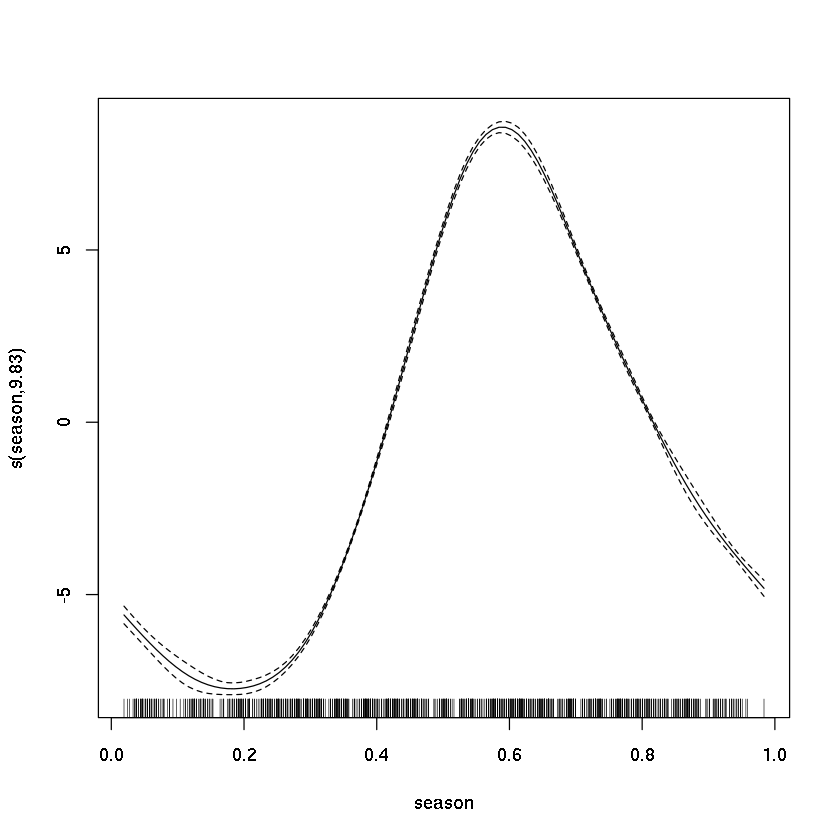

In [10]:
ices_gamm = gamm(temperature ~ s(decimalyear, bs="cr", k = length(x_values)) + s(season, bs="cc",k=12), data=icesdata, 
                 knots=list(decimalyear=x_values, season=c(0,1)), optimMethod="ML", 
                 correlation = corCAR1(form = ~ decimalyear|year))
plot(ices_gamm$gam)

Now we want to plot the temperature trend together with the data. To do so, we have to make a prediction term by term:

In [11]:
ices_gamm$gam$coefficients

(Intercept)  s(decimalyear).1  s(decimalyear).2  s(decimalyear).3 
       9.13389780       -2.68996241       -2.35917644       -1.98727395 
 s(decimalyear).4  s(decimalyear).5  s(decimalyear).6  s(decimalyear).7 
      -1.67579649       -1.36176245       -1.04065407       -0.82306146 
 s(decimalyear).8  s(decimalyear).9 s(decimalyear).10 s(decimalyear).11 
      -0.79009930       -0.19605507        0.02941994        0.03002634 
s(decimalyear).12 s(decimalyear).13 s(decimalyear).14 s(decimalyear).15 
       1.22173680        1.95419596        2.31974460        1.34629030 
      s(season).1       s(season).2       s(season).3       s(season).4 
      -6.38722798       -6.59266734       -4.91834886       -1.34533743 
      s(season).5       s(season).6       s(season).7       s(season).8 
       3.87310540        9.09111237        9.98226675        6.05238059 
      s(season).9      s(season).10 
       2.32899575       -0.79194631

In [13]:
# get the intercept - it is the first of the coefficients
intercept = ices_gamm$gam$coefficients[1]
intercept

# predict the terms one by one
my_prediction = predict(ices_gamm$gam,se.fit=TRUE,type="terms")
summary(my_prediction)

(Intercept) 
   9.133898

       Length Class  Mode   
fit    2150   -none- numeric
se.fit 2150   -none- numeric

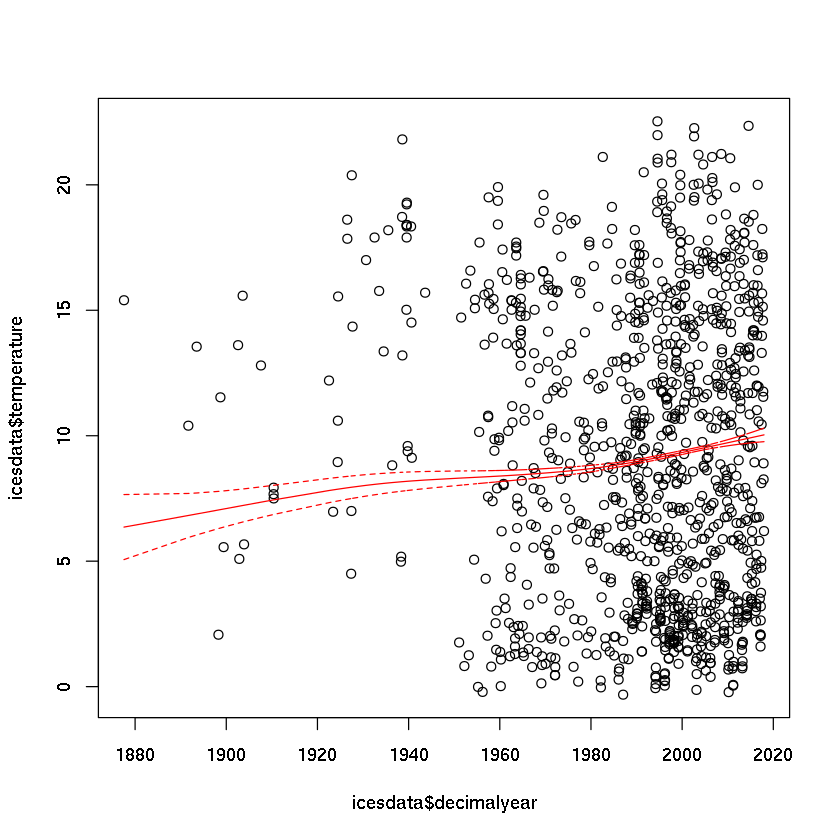

In [14]:
# get the temperature from the first columm
pred_temperature = intercept + my_prediction$fit[,1]

# get minimum and maximum temperature
pred_temperature_min = intercept + my_prediction$fit[,1] - 1.96*my_prediction$se.fit[,1]
pred_temperature_max = intercept + my_prediction$fit[,1] + 1.96*my_prediction$se.fit[,1]

# do the plot
plot(icesdata$decimalyear, icesdata$temperature)
lines(icesdata$decimalyear, pred_temperature, col="red")
lines(icesdata$decimalyear, pred_temperature_min, lty=2, col="red")
lines(icesdata$decimalyear, pred_temperature_max, lty=2, col="red")


Where is the trend significant? We define a function for that:

In [15]:
################################################
## Functions for derivatives of GAM(M) models ##
################################################
Deriv <- function(mod, n = 200, eps = 1e-7, newdata, term) {
    if(inherits(mod, "gamm"))
        mod <- mod$gam
    m.terms <- attr(terms(mod), "term.labels")
    if(missing(newdata)) {
        newD <- sapply(model.frame(mod)[, m.terms, drop = FALSE],
                       function(x) seq(min(x), max(x), length = n))
        names(newD) <- m.terms
    } else {
        newD <- newdata
    }
    newDF <- data.frame(newD) ## needs to be a data frame for predict
    X0 <- predict(mod, newDF, type = "lpmatrix")
    newDF <- newDF + eps
    X1 <- predict(mod, newDF, type = "lpmatrix")
    Xp <- (X1 - X0) / eps
    Xp.r <- NROW(Xp)
    Xp.c <- NCOL(Xp)
    ## dims of bs
    bs.dims <- sapply(mod$smooth, "[[", "bs.dim") - 1
    ## number of smooth terms
    t.labs <- attr(mod$terms, "term.labels")
    ## match the term with the the terms in the model
    if(!missing(term)) {
        want <- grep(term, t.labs)
        if(!identical(length(want), length(term)))
            stop("One or more 'term's not found in model!")
        t.labs <- t.labs[want]
    }
    nt <- length(t.labs)
    ## list to hold the derivatives
    lD <- vector(mode = "list", length = nt)
    names(lD) <- t.labs
    for(i in seq_len(nt)) {
        Xi <- Xp * 0
        want <- grep(t.labs[i], colnames(X1))
        Xi[, want] <- Xp[, want]
        df <- Xi %*% coef(mod)
        df.sd <- rowSums(Xi %*% mod$Vp * Xi)^.5
        lD[[i]] <- list(deriv = df, se.deriv = df.sd)
    }
    class(lD) <- "Deriv"
    lD$gamModel <- mod
    lD$eps <- eps
    lD$eval <- newD - eps
    lD ##return
}
                
# return those points where the derivative is 95% significant                       
signif_deriv = function(my_gamm,term,other_terms=NULL) {
    my_deriv = Deriv(my_gamm)
    deriv_is_significant = abs(my_deriv[[term]]$deriv)>1.96*abs(my_deriv[[term]]$se.deriv)
    x_values = data.frame(V1 = my_deriv$eval)
    colnames(x_values)=term
    if (!is.null(other_terms)) {
        for (other_term in other_terms) {
            x_values[,other_term]=0
        }
    }
    y_values = predict.gam(my_gamm$gam,newdata=x_values,type="terms")[,paste0("s(",term,")")]
    y_values[!deriv_is_significant]=NA
    y_values = y_values + my_gamm$gam$coefficients[1]
    return(data.frame(x=x_values[,term],y=y_values))
}

Now let's calculate where the trend is significant:

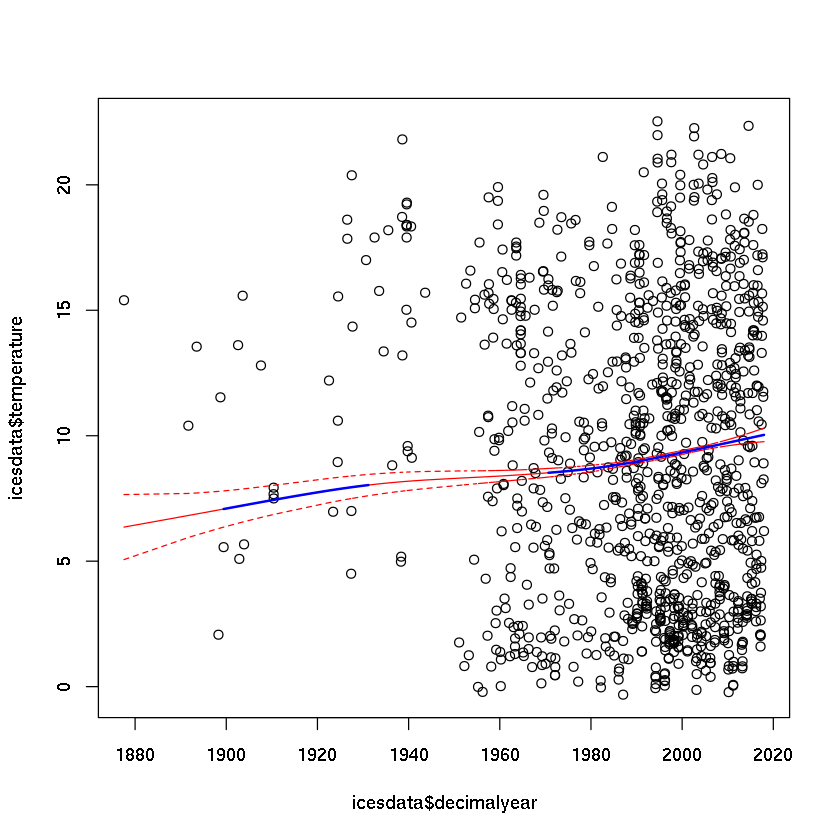

In [16]:


significant_derivative_points = signif_deriv(ices_gamm,term="decimalyear",other_terms = c("season"))
plot(icesdata$decimalyear, icesdata$temperature)
lines(icesdata$decimalyear, pred_temperature, col="red")
lines(icesdata$decimalyear, pred_temperature_min, lty=2, col="red")
lines(icesdata$decimalyear, pred_temperature_max, lty=2, col="red")
lines(significant_derivative_points, lwd=2, col="blue")